# Machine Learning - Pytorch

# Imports

Wir müssen die folgenden Libraries neu installieren. Dazu führe die nächste Zelle aus und starte die Runtime erneut ("Restart Runtime")

In [ ]:
!pip uninstall matplotlib
!pip install matplotlib==3.1.3
!pip install darts
!pip install pyyaml==5.4.0
!pip install xlrd==1.2.0

In [ ]:

import pandas as pd
import os, sys
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import plotly.express as px


from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler 
from sklearn.preprocessing import MaxAbsScaler
from darts.models import NBEATSModel, RNNModel, TFTModel, BlockRNNModel
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from darts.metrics import mape, rmse, mae
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, SunspotsDataset

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)


#  Daten 

In [ ]:
!curl -L https://github.com/NikolausHouben/HAB_Strom/blob/d0ac42bb653de446ab88d503a90433519dff6bfb/Daten/data_1.csv\?raw\=true -o data_1.csv
df_1 = pd.read_csv("data_1.csv", index_col = 0, parse_dates = True).resample("60T").mean()

!curl -L https://github.com/NikolausHouben/HAB_Strom/blob/d0ac42bb653de446ab88d503a90433519dff6bfb/Daten/data_2.csv\?raw\=true -o data_2.csv
df_2 = pd.read_csv("data_2.csv", index_col = 0, parse_dates = True).resample("60T").mean()


## Datenaufbereitung

* die Umwandlung des "Pandas.DataFrame" auf das "TimeSeries" Objekt is notwendig für die Darts Library
* float32 als Datenformat wird die Rechenzeit verkürzen

In [ ]:
series = TimeSeries.from_dataframe(df_1).astype("float32")


### Train-Val-Test Split

Zunächst teilen wir unsere TimeSeries,wie gehabt, in ein **Training Set** und ein **Validierungs Set**. Davor werden wir ein **Test Set** vorbereiten damit wir danach unser Modell auf ungesehen Daten **Backtesten** können.



In [ ]:
val_end = pd.Timestamp('2021-10-01 22:00:00')
train_and_dev_series, test = series.split_after(val_end)

train_end = pd.Timestamp('2021-09-01 22:00:00')
train, val = train_and_dev_series.split_after(train_end)

### Skalieren der Zeitreihe

Nun Skalieren (zwichen 0-1) wir unsere Daten, damit sie für ein Neural Network (speziell die nicht-lineare Activation Function) verwendbar sind

In [ ]:
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
scaler = Scaler(min_max_scaler)

train_transformed = scaler.fit_transform(train)
val_transformed = scaler.transform(val)
test_transformed = scaler.transform(test)


# Modellierung 




Wir bauen jetzt unsere Features:

* Welche bzw. wie viele Lag Features wir verwenden (ersichtlich z.B. durch ACF Plots; und begrenzt durch Rechenzeit)
* Welche zusätzlichen Features wir brauchen (Saisonalität)

In [ ]:
#Wie viele lags, und wie viele Zeitschritte voraus?
n_lags = 48 
n_ahead = 24

#Saisonalitäten
encoders = {
    'cyclic': {'future': ['weekday', 'hour']},
}



## Trainings-Parameter (Das sind alles sogenannte "Design Choices")

* Welchen Prozessor wir verwenden wollen.
* Wie viele Epochen der Trainingsprozess durchlaufen soll
* Wie hoch die Learning Rate vom Stochastic Gradient Descent Algorithmus sein soll: https://pytorch.org/docs/stable/optim.html


In [ ]:
device = 'gpu' if torch.cuda.is_available() else 'cpu'

print(device)

pl_trainer = {
      "accelerator": device,
      "gpus": [0]
      
    }


n_epochs = 100 #die Epochen (iterationen) durch das Trainings-Set

lr = {'lr': 1e-3} #Die Lernrate für SGD, kann man auch einen Scheduler verwenden

gpu


Bevor wir zu den Modellen springen, legen wir fest an wie vielen Tagen wir unsere Prognose "Backtesten" wollen.

In [ ]:
days = 10 # in tagen

## Modell (1): Gated Recurrent Unit – RNN

Chung, J., Gulcehre, C., Cho, K., & Bengio, Y. (2014). Empirical evaluation of gated recurrent neural networks on sequence modeling. arXiv preprint arXiv:1412.3555. https://doi.org/10.48550/arXiv.1412.3555

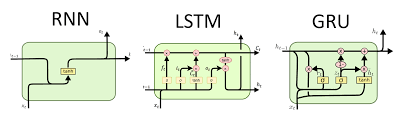

Das Modell wird initialisiert: 
* Wir verwenden das einfacherer GRU um die Trainingszeit minimal zu halten. Bei Bedarf kann man auch "LSTM" verwenden.

In [ ]:
my_model_1 = BlockRNNModel(
    model="GRU", 
    input_chunk_length=48,
    output_chunk_length=24,
    hidden_size=10,
    n_rnn_layers=1,
    batch_size=32,
    dropout=0.1,
    model_name="model_1",
    nr_epochs_val_period=1,
    optimizer_kwargs={"lr": 1e-3},
    log_tensorboard=True,
    random_state=42,
    force_reset=True,
    pl_trainer_kwargs = pl_trainer
)


Hier trainieren wir das Modell: Der Trainings Datensatz wird "n_epochs"-mal durchlaufen und das Modell mit dem geringsten Loss wird gespeichert.

In [ ]:
my_model_1.fit(
    train_transformed,
    val_series=val_transformed,
    verbose=True, epochs = n_epochs
)



Alternativ, kannst du das trainierte Modell vom Github importieren. (Das geht schneller)

In [ ]:
!curl -L https://github.com/NikolausHouben/HAB_Strom/blob/5c6e23216a92c06598e604356c27ef863900c295/Modelle/df_1/my_model_1.pt\?raw\=true -o my_model_1.pt
my_model_1 = BlockRNNModel.load("my_model_1.pt")

### Error Analysis auf dem Test Set

Backtesten heißt, dass wir die Performance unseres Modells am ungesehen "Test Set" messen.

In [ ]:
backtest_series_1 = my_model_1.historical_forecasts(
    test_transformed[:(24*days)+1],
    forecast_horizon=n_ahead,
    retrain=False,
    verbose=False,
)

In [ ]:

def eval_backtest(backtest_series, actual_series, horizon, transformer):

    unscaled_pred = transformer.inverse_transform(backtest_series)
    unscaled_gt = transformer.inverse_transform(actual_series)

    plt.figure(figsize = (40, 6))
    unscaled_pred.plot(label="pred")
    unscaled_gt.plot(label = "ground truth")
    plt.legend()
    plt.title(f"Backtest, starting: {horizon}-hour horizon")
    print(
        "MAPE: {:.2f}%".format(
            mape(
                unscaled_gt,
                unscaled_pred,
            )
        )
    )
    
    print(
        "RMSE: {:.2f}".format(
            rmse(
                unscaled_gt,
                unscaled_pred,
            )
        )
    )


In [ ]:
eval_backtest(backtest_series_1, test_transformed[val_transformed.end_time():backtest_series_1.end_time()], "24",  scaler)

## Modell (2): Temporal Fusion Transformer: 

Lim, B., Arık, S. Ö., Loeff, N., & Pfister, T. (2021). Temporal fusion transformers for interpretable multi-horizon time series forecasting. International Journal of Forecasting, 37(4), 1748-1764. https://doi.org/10.1016/j.ijforecast.2021.03.012


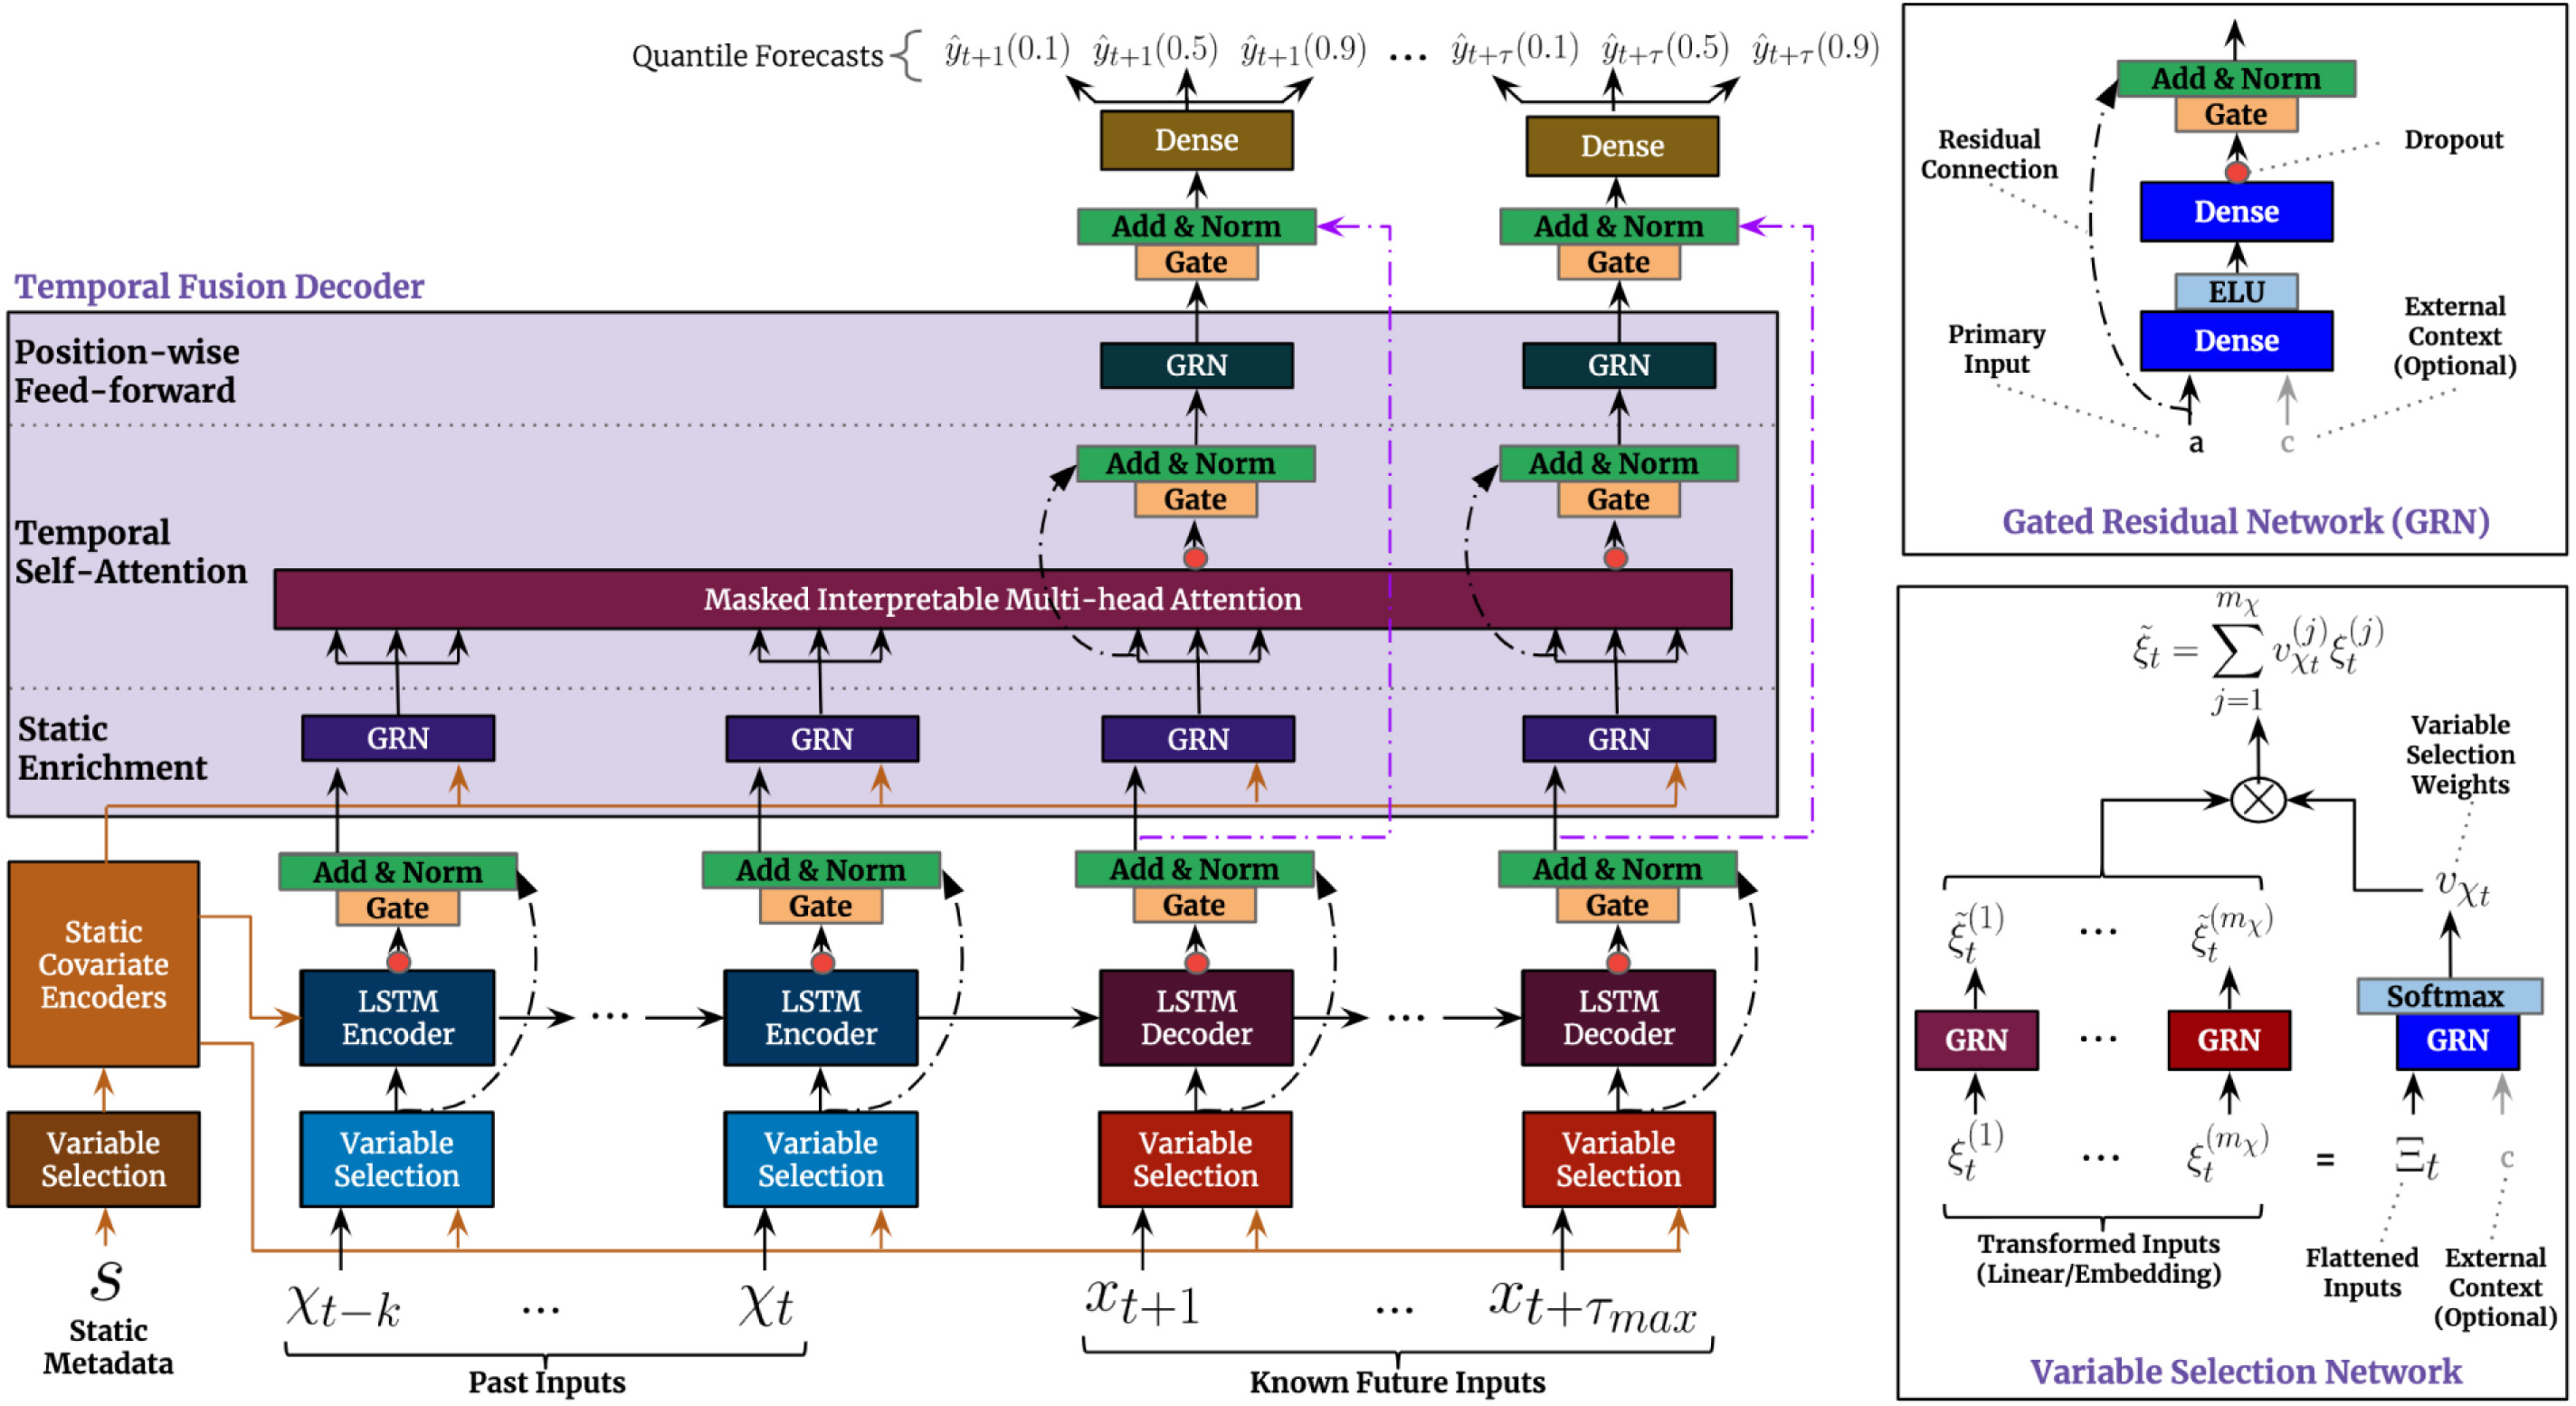

Das Modell wird initialisiert: 
* damit wir keine "Future Covariates" spezifizieren müssen, verwenden wir "add-relative-index = True"
* "likelihood = None", weil wir deterministisch prognostizieren

In [ ]:
my_model_2 = TFTModel(
    input_chunk_length=n_lags,
    output_chunk_length=n_ahead,
    hidden_size=16,
    lstm_layers=2,
    num_attention_heads=6,
    dropout=0.1,
    batch_size=32,
    add_relative_index=True, #damit wir keine "Future Covariates" spezifizieren müssen
    add_encoders=None,
    likelihood=None, #wir machen hier deterministische Prognosen
    random_state=42,
    optimizer_kwargs = lr,
    pl_trainer_kwargs= pl_trainer
)

In [ ]:
my_model_2.fit(series = train_transformed, val_series=val_transformed,  num_loader_workers=2, epochs=n_epochs)

In [ ]:
!curl -L https://github.com/NikolausHouben/HAB_Strom/blob/5c6e23216a92c06598e604356c27ef863900c295/Modelle/df_1/my_model_2.pt\?raw\=true -o my_model_2.pt
my_model_2 = TFTModel.load("my_model_2.pt")

In [ ]:
backtest_series_2 = my_model_2.historical_forecasts(
    test_transformed[:(24*days)+1],
    forecast_horizon=24,
    retrain=False,
    verbose=False,
)

In [ ]:
eval_backtest(backtest_series_2, test_transformed[val_transformed.start_time():backtest_series_2.end_time()], "24", scaler)

## Modell (3): Temporal Fusion Transformer mit mehr Features

* Energy cumsum
* Datetime attributes
* (Seasonal lags) - Selber einführen !



In [ ]:
def cumsum_per_day(df, col_name):

    """Calculates a cumsum features of a timeseires for column col_name per day. Index needs to be DateTimeIndex"""
    dfs = []
    for _, group in df.groupby(df.index.date):
        group["cumsum"] = group[[col_name]].cumsum()
        dfs.append(group)

    df_ = pd.concat(dfs, axis=0)[["cumsum"]]


    return df_

In [ ]:
past_cov_series = TimeSeries.from_dataframe(cumsum_per_day(df_1, "y_1")).astype("float32")

train_and_dev_cov_series, test_cov = past_cov_series.split_after(val_end)
train_cov, val_cov = train_and_dev_cov_series.split_after(train_end)


min_max_scaler_cov = MinMaxScaler(feature_range=(0, 1))
scaler_cov = Scaler(min_max_scaler_cov)

cov_train_transformed = scaler_cov.fit_transform(train_cov)
cov_val_transformed = scaler_cov.transform(val_cov)
cov_test_transformed = scaler_cov.transform(test_cov)


In [ ]:
my_model_3 = TFTModel(
    input_chunk_length=n_lags,
    output_chunk_length=n_ahead,
    hidden_size=16,
    lstm_layers=2,
    num_attention_heads=6,
    dropout=0.1,
    batch_size=1024,
    add_relative_index=False,
    add_encoders=encoders,
    likelihood=None,
    random_state=42,
    optimizer_kwargs = {'lr': 1e-3},
    pl_trainer_kwargs={
      "accelerator": "gpu",
      "gpus": [0]
    }
)


In [ ]:
my_model_3.fit(series = train_transformed, past_covariates=cov_train_transformed, val_series = val_transformed, val_past_covariates = cov_val_transformed, num_loader_workers=4, epochs=n_epochs)

In [ ]:

!curl -L https://github.com/NikolausHouben/HAB_Strom/blob/d0ac42bb653de446ab88d503a90433519dff6bfb/Modelle/df_1/my_model_3.pt\?raw\=true -o my_model_3.pt
my_model_3 = TFTModel.load("my_model_3.pt")



In [ ]:
backtest_series_3 = my_model_3.historical_forecasts(
    test_transformed[:(24*30)+1],
    forecast_horizon=n_ahead,
    past_covariates=cov_test_transformed,
    retrain=False,
    verbose=False,
)

In [ ]:
eval_backtest(backtest_series_3, test_transformed[val_transformed.start_time():pd.Timestamp("2021-11-01")], "24", scaler)